<a href="https://colab.research.google.com/github/IPutuArcana/ScrapPlaystore/blob/main/SenAnSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imbalanced-learn

Import Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix


Load Data

In [ ]:
df = pd.read_csv("hasil_scraper_ulasan_APP.csv")
df.head()

,reviewId,userName,rating,review_txt,date
0,52bbf5ac-5d5e-4784-8977-8e7e7d2ee1f4,Pengguna Google,5,semoga sesuai,2025-11-01 02:57:00
1,ae1d715f-e333-4e06-b7cc-2dff84e8d185,Pengguna Google,5,"Pemesanan lancar, mantap.",2025-11-01 02:56:37
2,36729071-3556-4049-a4d2-8fa06b8ee1bb,Pengguna Google,1,"mantap banyak bug nya, sejahtera indonesiaku",2025-11-01 00:47:39
3,4cc6d9fb-c97a-48d3-ba82-ef0f1fbeb735,Pengguna Google,5,oke,2025-10-31 22:12:36
4,2af0bdc5-25eb-417f-8a1b-d6ce91ccde90,Pengguna Google,5,manyap,2025-10-31 13:39:33


Bersihin teks

In [ ]:
def clean_text(t):
    t = str(t).lower()
    t = re.sub(r"http\S+", "", t)
    t = re.sub(r"[^a-zA-Z0-9\s]", " ", t)
    return t

df["clean"] = df["review_txt"].apply(clean_text)


labeling dari rating

In [ ]:
def label_sentiment(r):
    if r >= 4:
        return "positive"
    elif r == 3:
        return "neutral"
    else:
        return "negative"

df["label"] = df["rating"].apply(label_sentiment)
df.head()


,reviewId,userName,rating,review_txt,date,clean,label
0,52bbf5ac-5d5e-4784-8977-8e7e7d2ee1f4,Pengguna Google,5,semoga sesuai,2025-11-01 02:57:00,semoga sesuai,positive
1,ae1d715f-e333-4e06-b7cc-2dff84e8d185,Pengguna Google,5,"Pemesanan lancar, mantap.",2025-11-01 02:56:37,pemesanan lancar mantap,positive
2,36729071-3556-4049-a4d2-8fa06b8ee1bb,Pengguna Google,1,"mantap banyak bug nya, sejahtera indonesiaku",2025-11-01 00:47:39,mantap banyak bug nya sejahtera indonesiaku,negative
3,4cc6d9fb-c97a-48d3-ba82-ef0f1fbeb735,Pengguna Google,5,oke,2025-10-31 22:12:36,oke,positive
4,2af0bdc5-25eb-417f-8a1b-d6ce91ccde90,Pengguna Google,5,manyap,2025-10-31 13:39:33,manyap,positive


split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df["clean"], df["label"], test_size=0.2, random_state=42
)

TF-IDF Vectorizer

In [ ]:
vectorizer = TfidfVectorizer(
    max_features=60000,
    ngram_range=(1, 2),
    sublinear_tf=True,
    min_df=3
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


Oversampling neutral


In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train_vec, y_train)

Train SVM

In [ ]:
svm = LinearSVC(class_weight='balanced')
svm.fit(X_train_res, y_train_res)

LinearSVC(class_weight='balanced')

Evaluation the model

In [ ]:
y_pred = svm.predict(X_test_vec)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.87      0.85      0.86     12242
     neutral       0.16      0.23      0.19      1415
    positive       0.88      0.85      0.87      8463

    accuracy                           0.81     22120
   macro avg       0.64      0.64      0.64     22120
weighted avg       0.83      0.81      0.82     22120

[[10381  1188   673]
 [  810   322   283]
 [  777   504  7182]]


In [ ]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm

              precision    recall  f1-score   support

    negative       0.87      0.85      0.86     12242
     neutral       0.16      0.23      0.19      1415
    positive       0.88      0.85      0.87      8463

    accuracy                           0.81     22120
   macro avg       0.64      0.64      0.64     22120
weighted avg       0.83      0.81      0.82     22120



array([[10381,  1188,   673],
       [  810,   322,   283],
       [  777,   504,  7182]])

GRaph


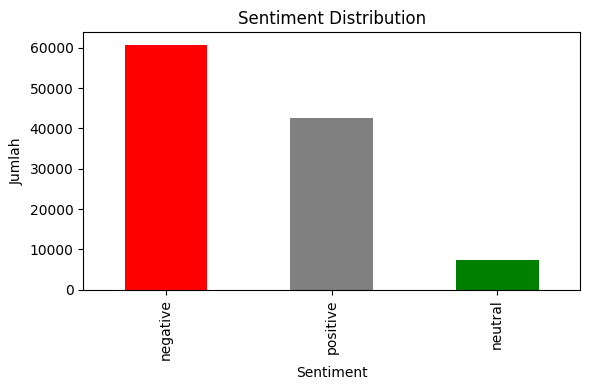

In [ ]:
plt.figure(figsize=(6,4))
df['label'].value_counts().plot(kind='bar', color=['red','gray','green'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()


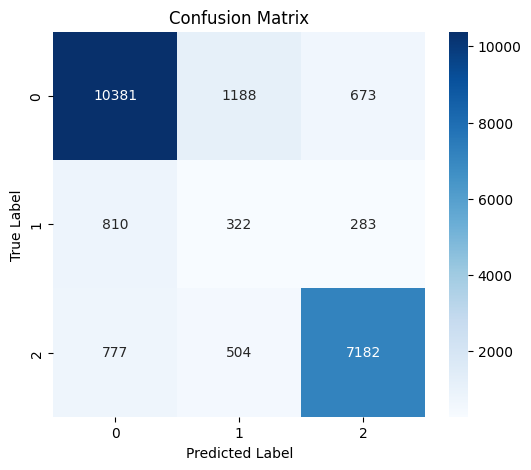

In [ ]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


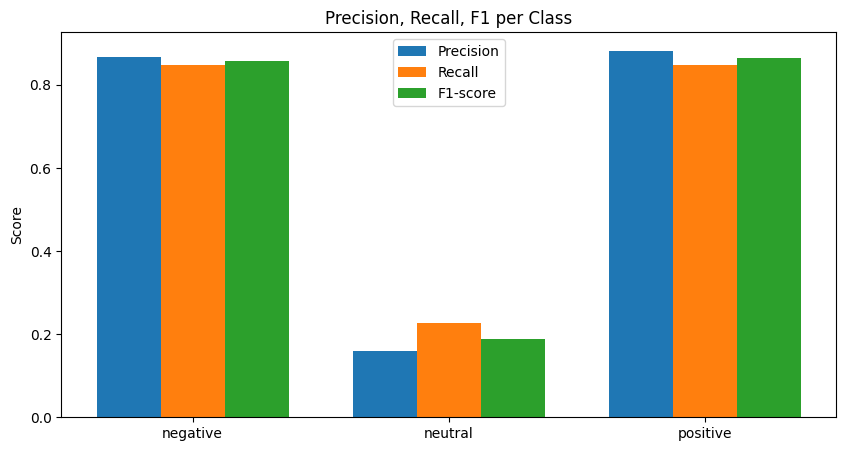

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

labels = ["negative","neutral","positive"]
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, labels=labels)

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10,5))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-score')

plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Precision, Recall, F1 per Class")
plt.legend()
plt.show()
